In [ ]:
#important library:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

2024-04-27 14:21:52.625111: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-27 14:21:52.625169: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-27 14:21:52.626856: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## load train and test data
# important steps we need:
- augmentation the train and test data for model to avoid the overfitting
- normalize the directories

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define constants
image_size = (224, 224)  # Rescale images to 224x224 pixels
batch_size = 32

# Define paths to the original training and test directories
train_dir = '/kaggle/input/melanoma-cancer-dataset/train'
test_dir = '/kaggle/input/melanoma-cancer-dataset/test'

# Get the list of subdirectories in the original training directory
subdirectories = os.listdir(train_dir)

# Split the subdirectories into training and validation sets
train_subdirs, validation_subdirs = train_test_split(subdirectories, test_size=0.2, random_state=42)

# Create directories for training and validation data
train_data_dir = 'path/to/train_data'
os.makedirs(train_data_dir, exist_ok=True)

validation_data_dir = 'path/to/validation_data'
os.makedirs(validation_data_dir, exist_ok=True)

# Move images to the corresponding directories
for subdir in subdirectories:
    filenames = os.listdir(os.path.join(train_dir, subdir))
    train_filenames, validation_filenames = train_test_split(filenames, test_size=0.3, random_state=42)

    for filename in train_filenames:
        src = os.path.join(train_dir, subdir, filename)
        dst = os.path.join(train_data_dir, subdir, filename)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

    for filename in validation_filenames:
        src = os.path.join(train_dir, subdir, filename)
        dst = os.path.join(validation_data_dir, subdir, filename)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

# Define data generators with augmentation for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Print the number of samples in each class for training and validation
print("Number of samples in training set:")
print(train_generator.classes)
print("\nNumber of samples in validation set:")
print(validation_generator.classes)

# Evaluate the model
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 8315 images belonging to 2 classes.
Found 3564 images belonging to 2 classes.
Number of samples in training set:
[0 0 0 ... 1 1 1]

Number of samples in validation set:
[0 0 0 ... 1 1 1]
Found 2000 images belonging to 2 classes.


In [ ]:
import numpy as np

# Get the class labels for training and validation sets
train_labels = train_generator.classes
validation_labels = validation_generator.classes

# Get the count of samples in each class
train_class_counts = np.unique(train_labels, return_counts=True)
validation_class_counts = np.unique(validation_labels, return_counts=True)

# Print the counts
print("Number of samples in each class for training set:")
for class_label, count in zip(train_class_counts[0], train_class_counts[1]):
    print(f"Class {class_label}: {count} samples")

print("\nNumber of samples in each class for validation set:")
for class_label, count in zip(validation_class_counts[0], validation_class_counts[1]):
    print(f"Class {class_label}: {count} samples")


Number of samples in each class for training set:
Class 0: 4402 samples
Class 1: 3913 samples

Number of samples in each class for validation set:
Class 0: 1887 samples
Class 1: 1677 samples


In [ ]:
import numpy as np

# Assuming you have a test generator similar to train and validation generators
test_labels = test_generator.classes

# Get the count of samples in each class
test_class_counts = np.unique(test_labels, return_counts=True)

# Print the counts
print("Number of samples in each class for test set:")
for class_label, count in zip(test_class_counts[0], test_class_counts[1]):
    print(f"Class {class_label}: {count} samples")


Number of samples in each class for test set:
Class 0: 1000 samples
Class 1: 1000 samples


- show the images in the train directory:

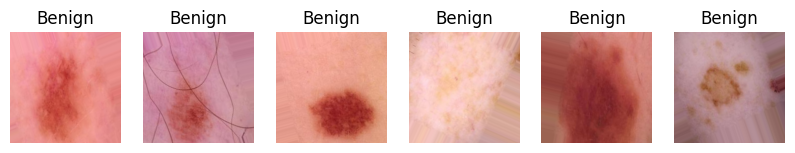

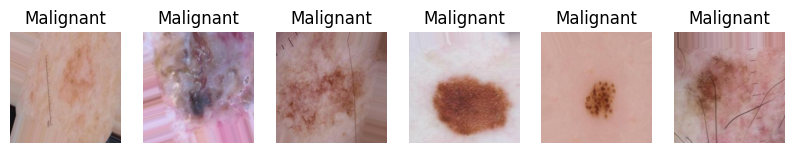

In [ ]:
import matplotlib.pyplot as plt

# Define the number of images to plot from each class
num_images_per_class = 6

# Get class indices
class_indices = test_generator.class_indices

# Inverse mapping of class indices to class labels
class_labels = {v: k for k, v in class_indices.items()}

# Plot images from each class
for class_index, class_label in class_labels.items():
    # Find the first num_images_per_class images belonging to the current class
    class_images = [image for image, label in zip(train_generator[0][0], train_generator[0][1]) if label[class_index] == 1][:num_images_per_class]

    # Plot the images
    plt.figure(figsize=(10, 5))
    for i, image in enumerate(class_images):
        plt.subplot(1, num_images_per_class, i + 1)
        plt.imshow(image)
        plt.title(class_label)
        plt.axis('off')
    plt.show()


- show the images in the test directory:

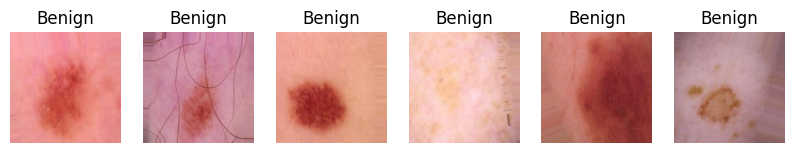

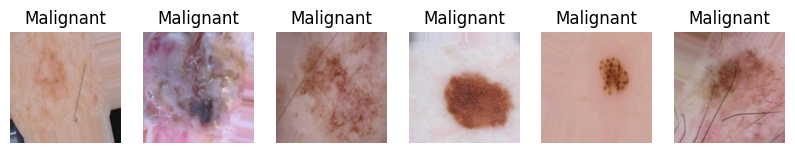

In [ ]:
import matplotlib.pyplot as plt

# Define the number of images to plot from each class
num_images_per_class = 6

# Get class indices
class_indices = train_generator.class_indices

# Inverse mapping of class indices to class labels
class_labels = {v: k for k, v in class_indices.items()}

# Plot images from each class
for class_index, class_label in class_labels.items():
    # Find the first num_images_per_class images belonging to the current class
    class_images = [image for image, label in zip(train_generator[0][0], train_generator[0][1]) if label[class_index] == 1][:num_images_per_class]

    # Plot the images
    plt.figure(figsize=(10, 5))
    for i, image in enumerate(class_images):
        plt.subplot(1, num_images_per_class, i + 1)
        plt.imshow(image)
        plt.title(class_label)
        plt.axis('off')
    plt.show()


- build the model:

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers, models

input_shape = (224, 224, 3)

base_model = EfficientNetB5(weights='imagenet', include_top=False, input_shape=input_shape, pooling='max')
x = base_model.output
x = layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)  # L2 regularization
x = layers.Dropout(0.3)(x)
output = layers.Dense(2, activation='softmax', kernel_regularizer=l2(0.01))(x)  # L2 regularization
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.0001)

model = models.Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

- train the model:

In [ ]:
import matplotlib.pyplot as plt

# Train the model and store the training history
history1 = model.fit(train_generator, epochs=50, validation_data=validation_generator)

# Plot training and testing accuracy



Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1714228049.977792     723 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


260/260 ━━━━━━━━━━━━━━━━━━━━ 622s 1s/step - accuracy: 0.6759 - loss: 3.4087 - val_accuracy: 0.5295 - val_loss: 3.3220
Epoch 2/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 116s 438ms/step - accuracy: 0.8095 - loss: 2.7126 - val_accuracy: 0.6249 - val_loss: 3.2328
Epoch 3/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 117s 438ms/step - accuracy: 0.8512 - loss: 2.5315 - val_accuracy: 0.8134 - val_loss: 2.5281
Epoch 4/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 116s 437ms/step - accuracy: 0.8518 - loss: 2.4259 - val_accuracy: 0.8650 - val_loss: 2.3327
Epoch 5/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 116s 437ms/step - accuracy: 0.8656 - loss: 2.2924 - val_accuracy: 0.8729 - val_loss: 2.2282
Epoch 6/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 116s 438ms/step - accuracy: 0.8781 - loss: 2.1883 - val_accuracy: 0.8793 - val_loss: 2.1302
Epoch 7/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 117s 439ms/step - accuracy: 0.8886 - loss: 2.0810 - val_accuracy: 0.8844 - val_loss: 2.0251
Epoch 8/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 117s 440ms/step - accuracy: 0.8876 - loss: 1.9892 

- test the trainable model:

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)

# Print the test accuracy
print("Test Accuracy:", test_accuracy)


63/63 ━━━━━━━━━━━━━━━━━━━━ 27s 429ms/step - accuracy: 0.9499 - loss: 0.4301
Test Accuracy: 0.9350000023841858


- plot the loss in each epoch

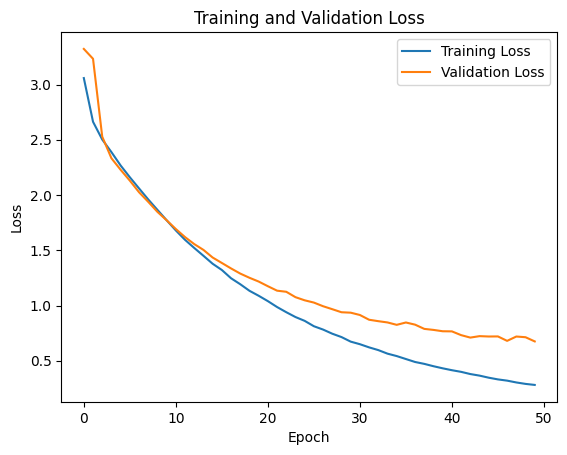

In [ ]:
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


- plot the accuracy in each epoch

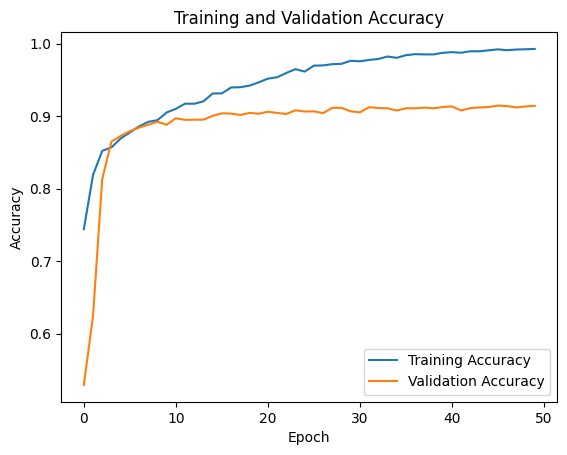

In [ ]:
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

- confusion matric and classification report:

In [ ]:
predictions = model.predict(test_generator)

predicted_labels = np.argmax(predictions, axis=1)

true_labels = test_generator.classes

conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)
print('----------------------------------------------------------------------------------------------')

class_report = classification_report(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)


63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step
Confusion Matrix:
[[948  52]
 [ 78 922]]
----------------------------------------------------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.94      1000
           1       0.95      0.92      0.93      1000

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.93      2000
weighted avg       0.94      0.94      0.93      2000



- plot the confusion matrix
:

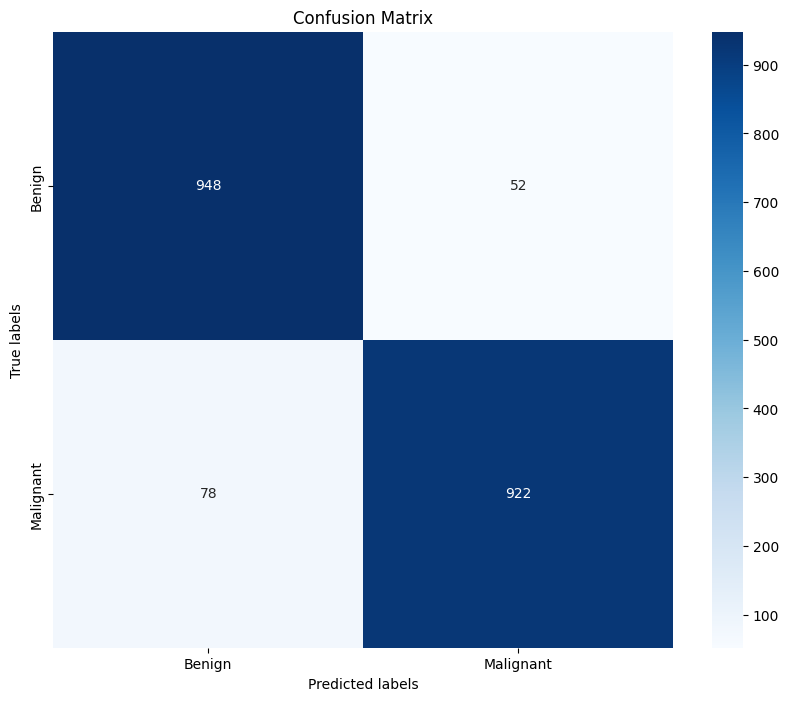

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

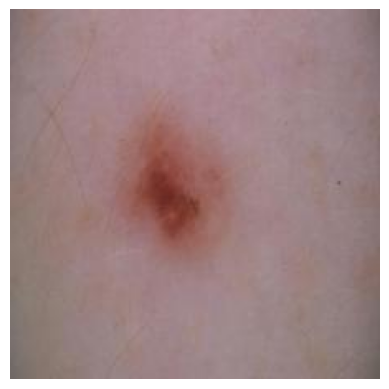

Predicted class: Benign (Probability: 0.92)


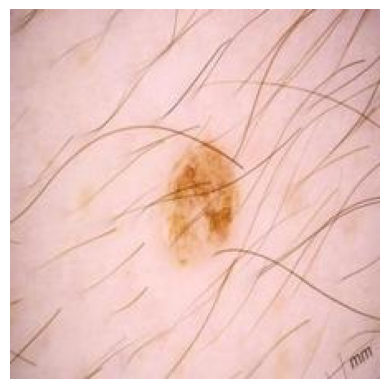

Predicted class: Benign (Probability: 1.00)


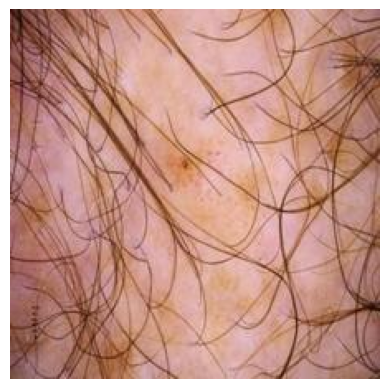

Predicted class: Benign (Probability: 0.99)


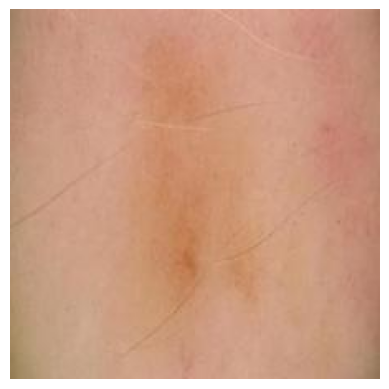

Predicted class: Benign (Probability: 1.00)


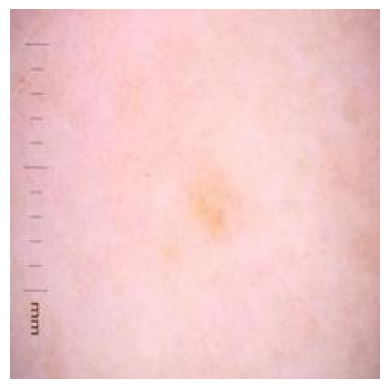

Predicted class: Benign (Probability: 1.00)


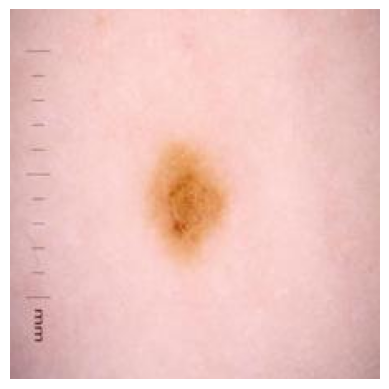

Predicted class: Benign (Probability: 1.00)


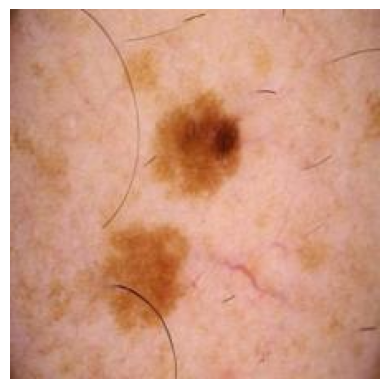

Predicted class: Benign (Probability: 1.00)


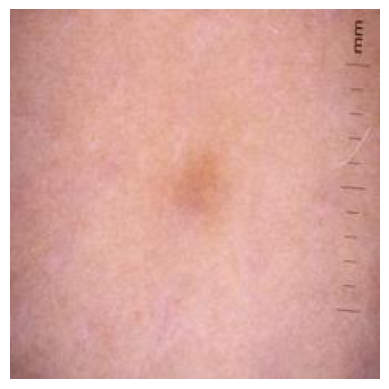

Predicted class: Benign (Probability: 1.00)


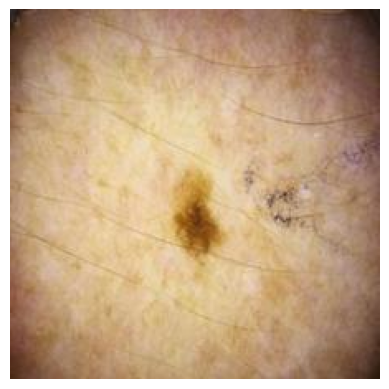

Predicted class: Benign (Probability: 1.00)


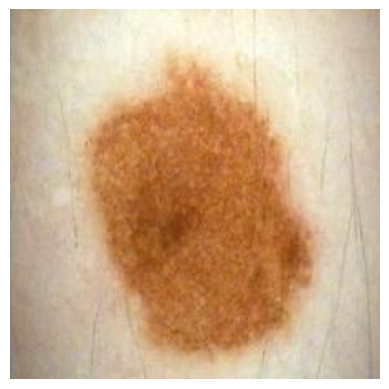

Predicted class: Benign (Probability: 1.00)


In [ ]:
# Iterate over the test generator and display predictions for 10 images
num_images_to_display = 10
for i, (image, label) in enumerate(test_generator):
    # Display the image
    plt.imshow(image[0])  # Assuming batch size is 1
    plt.axis('off')
    plt.show()

    # Get predicted class and probability
    predicted_class = np.argmax(predictions[i])
    predicted_probability = np.max(predictions[i])

    # Get actual class
    #ctual_class = class_labels[int(label[i])]  # Convert label to scalar integer
                                                # before using it as an index

    # Display predicted class, actual class, and probability
    print(f"Predicted class: {class_labels[predicted_class]} (Probability: {predicted_probability:.2f})")
    print("---------------------------------------



    # Break the loop after displaying predictions for 10 images
    if i == num_images_to_display - 1:
        break


